In [1]:
from IPython.core.pylabtools import figsize
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [2]:
# Get date
import os
from urllib.request import urlretrieve

def get_data():
    if os.path.exists('data/txtdata.csv'):
        return
    os.makedirs('data', exist_ok=True)
    urlretrieve('https://git.io/vXTVC', 'data/txtdata.csv')
    
get_data()

(0, 74)

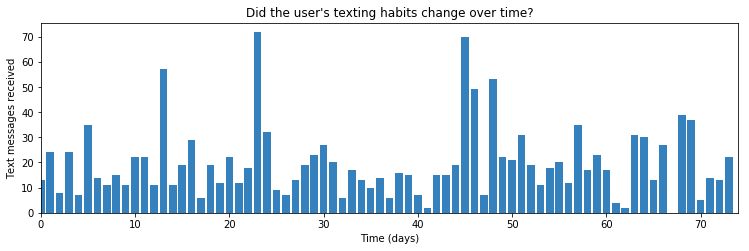

In [3]:
figsize(12.5, 3.5)
count_data = np.loadtxt('./data/txtdata.csv')
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color='#3481bd')

plt.xlabel('Time (days)')
plt.ylabel('Text messages received')
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data)

In [4]:
alpha = 1.0 / count_data.mean()
with pm.Model() as model:
    lambda_1 = pm.Exponential('lambda_1', alpha)
    lambda_2 = pm.Exponential('lambda_2', alpha)

    tau = pm.DiscreteUniform('tau', lower=0, upper=n_count_data)

In [9]:
with model:
    idx = np.arange(n_count_data)
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
    observation = pm.Poisson('obs', lambda_, observed=count_data)

In [10]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(1000, tune=5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2_log__]
>Metropolis: [lambda_1_log__]
100%|██████████| 6000/6000 [00:04<00:00, 1312.95it/s]
The number of effective samples is smaller than 25% for some parameters.


In [12]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

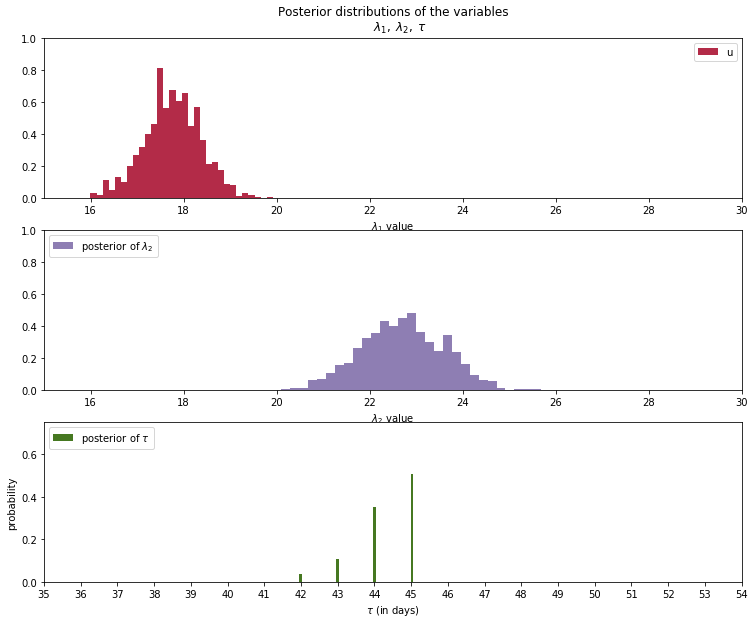

In [24]:
figsize(12.5, 10)

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85, label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend('upper left')
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

In [27]:
# 演習1: lambda_1, lambda_2 の平均

print('mean lambda_1: ', lambda_1_samples.mean())
print('mean lambda_2: ', lambda_2_samples.mean())

mean lambda_1:  17.76187189
mean lambda_2:  22.7085629709


In [32]:
# 演習2: メッセージ受信数の増加率

((lambda_2_samples - lambda_1_samples) / lambda_1_samples).mean()

0.2800242299347106

In [35]:
# 演習3: tau が 45 日よりも前という情報が与えられたときの lambda_1 の平均

indices = tau_samples < 45
lambda_1_samples[indices].mean()

17.736185402578812